# Project 2: Ames Housing Data and Kaggle Challenge

## Notebook Navigation

- [Creating and iteratively refining a regression model](#Creating-and-iteratively-refining-a-regression-model)
- [Data Dictionary](#Data-dictionary)

## Problem Statement

What are the top 5 factors that determines the Sales price in Ames?

## 1. Creating and iteratively refining a regression model

### Import libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn import metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Import and review data

###### Import Training data

In [3]:
# Import training data
df_train = pd.read_csv('../datasets/train.csv', keep_default_na=False)
# Initial inspection of training data
df_train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,,13517,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,130500
1,544,531379050,60,RL,43,11492,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,4,2009,WD,220000
2,153,535304180,20,RL,68,7922,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,1,2010,WD,109000
3,318,916386060,60,RL,73,9802,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,4,2010,WD,174000
4,255,906425045,50,RL,82,14235,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,138500


In [4]:
# Define function to rename columns
def rename_cols(df):
    df.columns = [col.replace(' ', '_') for col in df.columns.str.lower()]

In [5]:
rename_cols(df_train)

###### Data Cleaning

In [6]:
# Define function to convert all columns to appropriate dtypes
def convert_dtypes(df):
    ## Change ms_subclass dtype to str
    df['ms_subclass'] = df['ms_subclass'].astype(str)
    
    ## define columns to convert to numeric
    to_float = ['lot_frontage', 'lot_area', 'year_built',
               'year_remod/add', 'mas_vnr_area', 'bsmtfin_sf_1',
               'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
               '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
               'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath',
               'full_bath', 'half_bath', 'bedroom_abvgr',
               'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces',
               'garage_yr_blt', 'garage_cars', 'garage_area',
                'wood_deck_sf', 'open_porch_sf', 'enclosed_porch',
                '3ssn_porch', 'screen_porch', 'pool_area',
                'misc_val', 'mo_sold', 'yr_sold']       
    for col in to_float:
        df[col] = pd.to_numeric(df[col])
    
    ## convert nominal columns to ordinal
    df['lot_shape'] = df['lot_shape'].map({'IR3': 0,
                                           'IR2': 1,
                                           'IR1': 2,
                                           'Reg': 3})
    
    df['utilities'] = df['utilities'].map({'ELO': 0,
                                           'NoSeWa': 1,
                                           'NoSewr': 2,
                                           'AllPub': 3})
    
    df['land_slope'] = df['land_slope'].map({'Gtl': 0,
                                             'Mod': 1,
                                             'Sev': 2})
    
    df['exter_qual'] = df['exter_qual'].map({'Po': 0,
                                             'Fa': 1,
                                             'TA': 2,
                                             'Gd': 3,
                                             'Ex': 4})

    df['exter_cond'] = df['exter_cond'].map({'Po': 0,
                                             'Fa': 1,
                                             'TA': 2,
                                             'Gd': 3,
                                             'Ex': 4})
    
    df['bsmt_qual'] = df['bsmt_qual'].map({'NA': 0,
                                           'Po': 1,
                                           'Fa': 2,
                                           'TA': 3,
                                           'Gd': 4,
                                           'Ex': 5})
    
    df['bsmt_cond'] = df['bsmt_cond'].map({'NA': 0,
                                           'Po': 1,
                                           'Fa': 2,
                                           'TA': 3,
                                           'Gd': 4,
                                           'Ex': 5})

    df['bsmt_exposure'] = df['bsmt_exposure'].map({'NA': 0,
                                                   'No': 1,
                                                   'Mn': 2,
                                                   'Av': 3,
                                                   'Gd': 4})
    
    df['heating_qc'] = df['heating_qc'].map({'Po': 0,
                                             'Fa': 1,
                                             'TA': 2,
                                             'Gd': 3,
                                             'Ex': 4})
    
    df['kitchen_qual'] = df['kitchen_qual'].map({'Po': 0,
                                                 'Fa': 1,
                                                 'TA': 2,
                                                 'Gd': 3,
                                                 'Ex': 4})
    
    df['fireplace_qu'] = df['fireplace_qu'].map({'NA': 0,
                                                 'Po': 1,
                                                 'Fa': 2,
                                                 'TA': 3,
                                                 'Gd': 4,
                                                 'Ex': 5})
    
    df['garage_finish'] = df['garage_finish'].map({'NA': 0,
                                                   'Unf': 1,
                                                   'RFn': 2,
                                                   'Fin': 3})
    
    df['garage_qual'] = df['garage_qual'].map({'NA': 0,
                                               'Po': 1,
                                               'Fa': 2,
                                               'TA': 3,
                                               'Gd': 4,
                                               'Ex': 5})
    
    df['garage_cond'] = df['garage_cond'].map({'NA': 0,
                                               'Po': 1,
                                               'Fa': 2,
                                               'TA': 3,
                                               'Gd': 4,
                                               'Ex': 5})
    
    df['paved_drive'] = df['paved_drive'].map({'N': 0,
                                               'P': 1,
                                               'Y': 2})
    
    df['pool_qc'] = df['pool_qc'].map({'NA': 0,
                                       'Fa': 1,
                                       'TA': 2,
                                       'Gd': 3,
                                       'Ex': 4})
    
    ## convert nominal columns to binary
    df['central_air'] = df['central_air'].map({'N': 0,
                                               'Y': 1})

In [7]:
# Define function to impute missing variables
def impute_func(df):
    
    # Define ordinal variables
    ord_cols = ['lot_shape', 'utilities', 'land_slope',
                'overall_qual', 'overall_cond', 'exter_qual',
                'exter_cond', 'bsmt_qual', 'bsmt_cond',
                'bsmt_exposure', 'heating_qc', 'kitchen_qual',
                'fireplace_qu', 'garage_finish', 'garage_qual',
                'garage_cond', 'paved_drive', 'pool_qc']
    
    for col in df.columns:
        # Find numerical and ordinal variables
        if df[col].dtype == np.float64 or df[col].dtype == np.int64:
            
            # Check if column contains any null values
            if df[col].isnull().any():
                
                # Impute mean, for now...
                if  col not in ord_cols:
                    df[col].fillna(df[col].mean(),inplace=True)
                else:
                # Impute based on probability
                    print(f'Processing {col}.')
                    proba_dist = list(df[col].value_counts(normalize=True))
                    col_values = list(df[col].value_counts().index)
                    
                    df[col].fillna(random.choices(col_values, weights=proba_dist, k=1)[0],inplace=True)
        
        # Find nominal variables
        else:
            
            # Check if column contains any empty strings
            if len(df[df[col]=='']) != 0:
                proba_dist = list(df[col].loc[df[col] != ''].value_counts(normalize=True))
                col_values = list(df[col].loc[df[col] != ''].value_counts().index)
                
                df[col].replace('',random.choices(col_values, weights=proba_dist, k=1)[0],inplace=True)
            

In [8]:
convert_dtypes(df_train)
impute_func(df_train)

Processing bsmt_qual.
Processing bsmt_cond.
Processing bsmt_exposure.
Processing garage_finish.
Processing garage_qual.
Processing garage_cond.


## EDA

In [9]:
df_eda = df_train.copy()

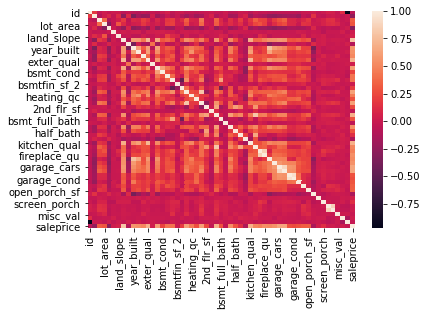

In [12]:
sns.heatmap(df_eda.corr());

In [43]:
df_train.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,69.0552,13517,Pave,NA,2,Lvl,...,0,0,0,NA,NA,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0000,11492,Pave,NA,2,Lvl,...,0,0,0,NA,NA,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0000,7922,Pave,NA,3,Lvl,...,0,0,0,NA,NA,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0000,9802,Pave,NA,3,Lvl,...,0,0,0,NA,NA,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0000,14235,Pave,NA,2,Lvl,...,0,0,0,NA,NA,0,3,2010,WD,138500


In [44]:
nom_col = [col for col in df_train.columns if df_train[col].dtype == np.object]
for col in nom_col:
    print(df_train[col].value_counts())

20     770
60     394
50     198
120    132
30     101
70      90
160     88
80      86
90      75
190     46
85      28
75      16
180     11
45      11
40       4
150      1
Name: ms_subclass, dtype: int64
RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64
Pave    2044
Grvl       7
Name: street, dtype: int64
NA      1911
Grvl      85
Pave      55
Name: alley, dtype: int64
Lvl    1843
HLS      85
Bnk      80
Low      43
Name: land_contour, dtype: int64
Inside     1503
Corner      348
CulDSac     131
FR2          60
FR3           9
Name: lot_config, dtype: int64
NAmes      310
CollgCr    180
OldTown    163
Edwards    143
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
NWAmes      87
SawyerW     87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      69
NoRidge     48
Timber      48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
Veenker   

In [45]:
# for col in df_train.columns:
#     if df_train[col].dtype == np.object:
#         df_train = pd.get_dummies(df_train, columns=[col],drop_first=False)

In [46]:
df_train.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,69.0552,13517,Pave,NA,2,Lvl,...,0,0,0,NA,NA,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0000,11492,Pave,NA,2,Lvl,...,0,0,0,NA,NA,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0000,7922,Pave,NA,3,Lvl,...,0,0,0,NA,NA,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0000,9802,Pave,NA,3,Lvl,...,0,0,0,NA,NA,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0000,14235,Pave,NA,2,Lvl,...,0,0,0,NA,NA,0,3,2010,WD,138500


In [47]:
# bsmt_cols = ['bsmtfin_sf_1','bsmtfin_sf_2','bsmt_unf_sf','total_bsmt_sf']
# if (df_realnum[bsmt_cols].isnull().any().any() == True):
#     for col in bsmt_cols:
            

In [48]:
# df_train[df_train['bsmtfin_sf_2'].isnull()].loc[:,'bsmtfin_sf_1']

### Creating model

In [49]:
predictors = [col for col in df_train.columns.drop(['id','pid','saleprice']) if df_train[col].dtype != np.object]

In [50]:
X = df_train[predictors]
y = df_train['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X,y)

### Model pre-processing: Scaling

In [51]:
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

### Creating model

In [52]:
lasso = LassoCV(n_alphas=200)
lasso.fit(X_train_scaled, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=200, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [53]:
lasso.score(X_test_scaled,y_test)

0.762228869553678

In [54]:
lasso.coef_

array([ 3743.11735749,  4295.8339563 ,  -712.79969026,     0.        ,
           0.        , 16317.92174587,  3672.99655917,  5032.17863476,
         137.39652751,  3820.62858651,  9205.2654732 ,     0.        ,
        3830.91329679, -2655.24496208,  4041.12312878,  7435.13049773,
           0.        ,    -0.        ,  6947.64645366,  1511.19136027,
          -0.        ,  2096.10451476,     0.        ,  -298.66725959,
       21141.02845306,   542.08066915, -1149.21865556,     0.        ,
           0.        ,  -325.87577671, -1159.29010395,  6856.608531  ,
        1544.99647346,     0.        ,  3747.18110694,   436.76116473,
         135.53878306,     0.        ,  6431.5667028 ,    -0.        ,
        -739.9162855 ,     0.        ,  1335.21291304,    -0.        ,
           0.        ,     0.        ,  3247.25442521,     0.        ,
           0.        , -7946.27947934,     0.        ,   -83.22152078])

In [55]:
cross_val_score(lasso,X_test_scaled,y_test).mean()

0.6560317004874099

## Make predictions using model

###### Import Test data

In [56]:
df_test = pd.read_csv('../datasets/test.csv', keep_default_na=False)
df_test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NA,NA,NA,0,4,2006,WD
1,2718,905108090,90,RL,,9662,Pave,NA,IR1,Lvl,...,0,0,0,NA,NA,NA,0,8,2006,WD
2,2414,528218130,60,RL,58,17104,Pave,NA,IR1,Lvl,...,0,0,0,NA,NA,NA,0,9,2006,New
3,1989,902207150,30,RM,60,8520,Pave,NA,Reg,Lvl,...,0,0,0,NA,NA,NA,0,7,2007,WD
4,625,535105100,20,RL,,9500,Pave,NA,IR1,Lvl,...,0,185,0,NA,NA,NA,0,7,2009,WD


In [57]:
# Rename columns
rename_cols(df_test)

In [58]:
df_test['ms_zoning'].unique()

array(['RM', 'RL', 'FV', 'RH', 'C (all)', 'I (all)'], dtype=object)

In [59]:
# Convert columns to appropriate data types
convert_dtypes(df_test)

In [60]:
# Fill in missing values
impute_func(df_test)

Processing garage_finish.


In [61]:
df_test['ms_zoning'].value_counts()

RL         675
RM         146
FV          38
RH          13
C (all)      6
I (all)      1
Name: ms_zoning, dtype: int64

In [62]:
df_test.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type
0,2658,902301120,190,RM,69.000000,9142,Pave,Grvl,3,Lvl,...,0,0,0,0,NA,NA,0,4,2006,WD
1,2718,905108090,90,RL,69.630042,9662,Pave,NA,2,Lvl,...,0,0,0,0,NA,NA,0,8,2006,WD
2,2414,528218130,60,RL,58.000000,17104,Pave,NA,2,Lvl,...,0,0,0,0,NA,NA,0,9,2006,New
3,1989,902207150,30,RM,60.000000,8520,Pave,NA,3,Lvl,...,0,0,0,0,NA,NA,0,7,2007,WD
4,625,535105100,20,RL,69.630042,9500,Pave,NA,2,Lvl,...,0,185,0,0,NA,NA,0,7,2009,WD


In [63]:
# for col in df_test.columns:
#     if df_test[col].dtype == np.object:
#         df_test = pd.get_dummies(df_test, columns=[col],drop_first=False)

In [64]:
test_predictors = [col for col in df_test.columns.drop(['id','pid']) if df_test[col].dtype != np.object]
X = df_test[test_predictors]
X_scaled = ss.transform(X)

In [65]:
a = set(list(predictors))

In [66]:
b = set(list(test_predictors))
print(a.difference(b))

set()


In [67]:
pred = lasso.predict(X_scaled)

In [68]:
type(df_test['id'].values)

numpy.ndarray

In [69]:
df_sub = pd.DataFrame({'Id': df_test['id'].values, 'SalePrice' : pred})

In [70]:
df_sub.to_csv('../datasets/submission.csv', index=False)

### Generate Submission data

###### Import Submission Example data

In [38]:
df_sample_sub_reg = pd.read_csv('../datasets/sample_sub_reg.csv')
df_sample_sub_reg.head()

,Id,SalePrice
0,2,181479.1217
1,4,181479.1217
2,6,181479.1217
3,7,181479.1217
4,17,181479.1217


##  Data dictionary

|Column|Type|Description| 
|:-:|:-:|:-|
|id|int|**ID**|
|pid|int|**Property ID Number**|
|ms_subclass|int|**The building class** <br> 20 : 1-STORY 1946 & NEWER ALL STYLES <br>30 : 1-STORY 1945 & OLDER<br>40 : 1-STORY W/FINISHED ATTIC ALL AGES<br>45 : 1-1/2 STORY - UNFINISHED ALL AGES<br>50 : 1-1/2 STORY FINISHED ALL AGES<br>60 : 2-STORY 1946 & NEWER<br>70 : 2-STORY 1945 & OLDER<br>75 : 2-1/2 STORY ALL AGES<br>80 : SPLIT OR MULTI-LEVEL<br>85 : SPLIT FOYER<br>90 : DUPLEX - ALL STYLES AND AGES<br>120 : 1-STORY PUD (Planned Unit Development) - 1946 & NEWER<br>150 : 1-1/2 STORY PUD - ALL AGES<br>160 : 2-STORY PUD - 1946 & NEWER<br>180 : PUD - MULTILEVEL - INCL SPLIT LEV/FOYER<br>190 : 2 FAMILY CONVERSION - ALL STYLES AND AGES|
|ms_zoning|object|**Identifies the general zoning classification of the sale.**<br>A : Agriculture<br>C : Commercial<br>FV : Floating Village Residential<br>I : Industrial<br>RH : Residential High Density<br>RL : Residential Low Density<br>RP : Residential Low Density Park<br>RM : Residential Medium Density|
|lot_frontage|float|**Linear feet of street connected to property**|
|lot_area|int|**Lot size in square feet**|
|street|object|**Type of road access to property**<br>Grvl : Gravel<br>Pave : Paved|
|alley|object|**Type of alley access to property**<br>Grvl : Gravel<br>Pave : Paved<br>NA : No alley access|
|lot_shape|object|**LotShape: General shape of property**<br>Reg : Regular<br>IR1 : Slightly irregular<br>IR2 : Moderately Irregular<br>IR3 : Irregular|
|land_contour|object|**LandContour: Flatness of the property**<br>Lvl : Near Flat/Level<br>Bnk : Banked - Quick and significant rise from street grade to building<br>HLS : Hillside - Significant slope from side to side<br>Low Depression|
|utilities|object|**Type of utilities available**<br>AllPub : All public Utilities (E,G,W,& S)<br>NoSewr : Electricity, Gas, and Water (Septic Tank)<br>NoSeWa : Electricity and Gas Only<br>ELO : Electricity only|
|lot_config|object|**Lot configuration**<br>Inside : Inside lot<br>Corner : Corner lot<br>CulDSac : Cul-de-sac<br>FR2 : Frontage on 2 sides of property<br>FR3 : Frontage on 3 sides of property|
|land_slope|object|**Slope of property**<br>Gtl : Gentle slope<br>Mod : Moderate Slope<br>Sev : Severe Slope|
|neighborhood|object|**Physical locations within Ames city limits**<br>Blmngtn : Bloomington Heights<br>Blueste : Bluestem<br>BrDale : Briardale<br>BrkSide : Brookside<br>ClearCr : Clear Creek<br>CollgCr : College Creek<br>Crawfor : Crawford<br>Edwards : Edwards<br>Gilbert : Gilbert<br>IDOTRR : Iowa DOT and Rail Road<br>Meadow : Meadow Village<br>Mitchel : Mitchell<br>Names : North Ames<br>NoRidge : Northridge<br>NPkVill : Northpark Villa<br>NridgHt : Northridge Heights<br>NWAmes : Northwest Ames<br>OldTown : Old Town<br>SWISU : South & West of Iowa State University<br>Sawyer : Sawyer<br>SawyerW : Sawyer West<br>Somerst : Somerset<br>StoneBr : Stone Brook<br>Timber : Timberland<br>Veenker : Veenker|
|condition_1|object|**Proximity to main road or railroad**<br>Artery : Adjacent to arterial street<br>Feedr : Adjacent to feeder street<br>Norm : Normal<br>RRNn : Within 200' of North-South Railroad<br>RRAn : Adjacent to North-South Railroad<br>PosN : Near positive off-site feature--park, greenbelt, etc.<br>PosA : Adjacent to postive off-site feature<br>RRNe : Within 200' of East-West Railroad<br>RRAe : Adjacent to East-West Railroad|
|condition_2|object|**Proximity to main road or railroad (if a second is present)**<br>Artery : Adjacent to arterial street<br>Feedr : Adjacent to feeder street<br>Norm : Normal<br>RRNn : Within 200' of North-South Railroad<br>RRAn : Adjacent to North-South Railroad<br>PosN : Near positive off-site feature--park, greenbelt, etc.<br>PosA : Adjacent to postive off-site feature<br>RRNe : Within 200' of East-West Railroad<br>RRAe : Adjacent to East-West Railroad|
|bldg_type|object|**Type of dwelling**<br>1Fam : Single-family Detached<br>2FmCon : Two-family Conversion; originally built as one-family dwelling<br>Duplx : Duplex<br>TwnhsE : Townhouse End Unit<br>TwnhsI : Townhouse Inside Unit|
|house_style|object|**Style of dwelling**<br>1Story : One story<br>1.5Fin : One and one-half story: 2nd level finished<br>1.5Unf : One and one-half story: 2nd level unfinished<br>2Story : Two story<br>2.5Fin : Two and one-half story: 2nd level finished<br>2.5Unf : Two and one-half story: 2nd level unfinished<br>SFoyer : Split Foyer<br>SLvl : Split Level|
|overall_qual|int|**Overall material and finish quality**<br>10 : Very Excellent<br>9 : Excellent<br>8 : Very Good<br>7 : Good<br>6 : Above Average<br>5 : Average<br>4 : Below Average<br>3 : Fair<br>2 : Poor<br>1 : Very Poor|
|overall_cond|int|**Overall condition rating**<br>10 : Very Excellent<br>9 : Excellent<br>8 : Very Good<br>7 : Good<br>6 : Above Average<br>5 : Average<br>4 : Below Average<br>3 : Fair<br>2 : Poor<br>1 : Very Poor|
|year_built|int|**Original construction date**|
|year_remod/add|int|**Remodel date (same as construction date if no remodeling or additions)**|
|roof_style|object|**Type of roof**<br>Flat : Flat<br>Gable : Gable<br>Gambrel : Gabrel (Barn)<br>Hip : Hip<br>Mansard : Mansard<br>Shed : Shed|
|roof_matl|object|**Roof material**<br>ClyTile : Clay or Tile<br>CompShg : Standard (Composite) Shingle<br>Membran : Membrane<br>Metal : Metal<br>Roll : Roll<br>Tar&Grv : Gravel & Tar<br>WdShake : Wood Shakes<br>WdShngl : Wood Shingles|
|exterior_1st|object|**Exterior covering on house**<br>AsbShng : Asbestos Shingles<br>AsphShn : Asphalt Shingles<br>BrkComm : Brick Common<br>BrkFace : Brick Face<br>CBlock : Cinder Block<br>CemntBd : Cement Board<br>HdBoard : Hard Board<br>ImStucc : Imitation Stucco<br>MetalSd : Metal Siding<br>Other : Other<br>Plywood : Plywood<br>PreCast : PreCast<br>Stone : Stone<br>Stucco : Stucco<br>VinylSd : Vinyl Siding<br>Wd Sdng : Wood Siding<br>WdShing : Wood Shingles|
|exterior_2nd|object|**Exterior covering on house (if more than one material)**<br>AsbShng : Asbestos Shingles<br>AsphShn : Asphalt Shingles<br>BrkComm : Brick Common<br>BrkFace : Brick Face<br>CBlock : Cinder Block<br>CemntBd : Cement Board<br>HdBoard : Hard Board<br>ImStucc : Imitation Stucco<br>MetalSd : Metal Siding<br>Other : Other<br>Plywood : Plywood<br>PreCast : PreCast<br>Stone : Stone<br>Stucco : Stucco<br>VinylSd : Vinyl Siding<br>Wd Sdng : Wood Siding<br>WdShing : Wood Shingles|
|mas_vnr_type|object|**Masonry veneer type**<br>BrkCmn : Brick Common<br>BrkFace : Brick Face<br>Block : Cinder Block<br>None : None<br>Stone : Stone|
|mas_vnr_area|float|**Masonry veneer area in square feet**|
|exter_qual|object|**Exterior material quality**<br>Ex : Excellent<br>Gd : Good<br>TA : Average/Typical<br>Fa : Fair<br>Po : Poor|
|exter_cond|object|**Present condition of the material on the exterior**<br>Ex : Excellent<br>Gd : Good<br>TA : Average/Typical<br>Fa : Fair<br>Po : Poor|
|foundation|object|**Type of foundation**<br>BrkTil : Brick & Tile<br>CBlock : Cinder Block<br>PConc : Poured Contrete<br>Slab : Slab<br>Stone : Stone<br>Wood : Wood|
|bsmt_qual|object|**Height of the basement**<br>Ex : Excellent (100+ inches)<br>Gd : Good (90-99 inches)<br>TA : Typical (80-89 inches)<br>Fa : Fair (70-79 inches)<br>Po : Poor (<70 inches)<br>NA : No Basement|
|bsmt_cond|object|General condition of the basement<br>Ex : Excellent<br>Gd : Good<br>TA : Typical - slight dampness allowed<br>Fa : Fair - dampness or some cracking or settling<br>Po : Poor - Severe cracking, settling, or wetness<br>NA : No Basement|
|bsmt_exposure|object|**Walkout or garden level basement walls**<br>Gd : Good Exposure<br>Av : Average Exposure (split levels or foyers typically score average or above)<br>Mn : Mimimum Exposure<br>No : No Exposure<br>NA : No Basement|
|bsmtfin_type_1|object|**Quality of basement finished area**<br>GLQ : Good Living Quarters<br>ALQ : Average Living Quarters<br>BLQ : Below Average Living Quarters<br>Rec : Average Rec Room<br>LwQ : Low Quality<br>Unf : Unfinshed<br>NA : No Basement|
|bsmtfin_sf_1|float|**Type 1 finished square feet**|
|bsmtfin_type_2|object|**Quality of second finished area (if present)**<br>GLQ : Good Living Quarters<br>ALQ : Average Living Quarters<br>BLQ : Below Average Living Quarters<br>Rec : Average Rec Room<br>LwQ : Low Quality<br>Unf : Unfinshed<br>NA : No Basement|
|bsmtfin_sf_2|float|**Type 2 finished square feet**|
|bsmt_unf_sf|float|**Unfinished square feet of basement area**|
|total_bsmt_sf|float|**Total square feet of basement area**|
|heating|object|**Type of heating**<br>Floor : Floor Furnace<br>GasA : Gas forced warm air furnace<br>GasW : Gas hot water or steam heat<br>Grav : Gravity furnace<br>OthW : Hot water or steam heat other than gas<br>Wall : Wall furnace|
|heating_qc|object|**Heating quality and condition**<br>Ex : Excellent<br>Gd : Good<br>TA : Average/Typical<br>Fa : Fair<br>Po : Poor|
|central_air|object|**Central air conditioning**<br>N : No<br>Y : Yes|
|electrical|object|**Electrical system**<br>SBrkr : Standard Circuit Breakers & Romex<br>FuseA : Fuse Box over 60 AMP and all Romex wiring (Average)<br>FuseF : 60 AMP Fuse Box and mostly Romex wiring (Fair)<br>FuseP : 60 AMP Fuse Box and mostly knob & tube wiring (poor)<br>Mix : Mixed|
|1st_flr_sf|int|**First Floor square feet**|
|2nd_flr_sf|int|**Second floor square feet**|
|low_qual_fin_sf|int|**Low quality finished square feet (all floors)**|
|gr_liv_area|int|**Above grade (ground) living area square feet**|
|bsmt_full_bath|float|**Basement full bathrooms**|
|bsmt_half_bath|float|**Basement half bathrooms**|
|full_bath|int|**Full bathrooms above grade**|
|half_bath|int|**Half baths above grade**|
|bedroom_abvgr|int|**Number of bedrooms above basement level**|
|kitchen_abvgr|int|**Number of kitchens**|
|kitchen_qual|object|**Kitchen quality**<br>Ex : Excellent<br>Gd : Good<br>TA : Typical/Average<br>Fa : Fair<br>Po : Poor|
|totrms_abvgrd|int|**Total rooms above grade (does not include bathrooms)**|
|functional|object|**Home functionality rating**<br>Typ : Typical Functionality<br>Min1 : Minor Deductions 1<br>Min2 : Minor Deductions 2<br>Mod : Moderate Deductions<br>Maj1 : Major Deductions 1<br>Maj2 : Major Deductions 2<br>Sev : Severely Damaged<br>Sal : Salvage only|
|fireplaces|int|**Number of fireplaces**|
|fireplace_qu|object|**Fireplace quality**<br>Ex : Excellent - Exceptional Masonry Fireplace<br>Gd : Good - Masonry Fireplace in main level<br>TA : Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement<br>Fa : Fair - Prefabricated Fireplace in basement<br>Po : Poor - Ben Franklin Stove<br>NA : No Fireplace|
|garage_type|object|**Garage location**<br>2Types : More than one type of garage<br>Attchd : Attached to home<br>Basment : Basement Garage<br>BuiltIn : Built-In (Garage part of house - typically has room above garage)<br>CarPort : Car Port<br>Detchd : Detached from home<br>NA : No Garage|
|garage_yr_blt|float|**Year garage was built**|
|garage_finish|object|**Interior finish of the garage**<br>Fin : Finished<br>RFn : Rough Finished<br>Unf : Unfinished<br>NA : No Garage|
|garage_cars|float|**Size of garage in car capacity**|
|garage_area|float|**Size of garage in square feet**|
|garage_qual|object|**Garage quality**<br>Ex : Excellent<br>Gd : Good<br>TA : Typical/Average<br>Fa : Fair<br>Po : Poor<br>NA : No Garage|
|garage_cond|object|**Garage condition**<br>Ex : Excellent<br>Gd : Good<br>TA : Typical/Average<br>Fa : Fair<br>Po : Poor<br>NA : No Garage|
|paved_drive|object|**Paved driveway**<br>Y : Paved<br>P : Partial Pavement<br>N : Dirt/Gravel|
|wood_deck_sf|int|**Wood deck area in square feet**|
|open_porch_sf|int|**Open porch area in square feet**|
|enclosed_porch|int|**Enclosed porch area in square feet**|
|3ssn_porch|int|**Three season porch area in square feet**|
|screen_porch|int|**Screen porch area in square feet**|
|pool_area|int|**Pool area in square feet**|
|pool_qc|object|**Pool quality**<br>Ex : Excellent<br>Gd : Good<br>TA : Average/Typical<br>Fa : Fair<br>NA : No Pool|
|fence|object|**Fence quality**<br>GdPrv : Good Privacy<br>MnPrv : Minimum Privacy<br>GdWo : Good Wood<br>MnWw : Minimum Wood/Wire<br>NA : No Fence|
|misc_feature|object|**Miscellaneous feature not covered in other categories**<br>Elev : Elevator<br>Gar2 : 2nd Garage (if not described in garage section)<br>Othr : Other<br>Shed : Shed (over 100 SF)<br>TenC : Tennis Court<br>NA : None|
|misc_val|int|**$Value of miscellaneous feature**|
|mo_sold|int|**Month Sold**|
|yr_sold|int|**Year Sold**|
|sale_type|object|**Type of sale**<br>WD : Warranty Deed - Conventional<br>CWD : Warranty Deed - Cash<br>VWD : Warranty Deed - VA Loan<br>New : Home just constructed and sold<br>COD : Court Officer Deed/Estate<br>Con : Contract 15\% Down payment regular terms<br>ConLw : Contract Low Down payment and low interest<br>ConLI : Contract Low Interest<br>ConLD : Contract Low Down<br>Oth : Other|
|saleprice|int|**Property's sale price in dollars**|

## 2. Using Kaggle to practice the modeling process

## 3. Providing business insights through reporting and presentation.